# Introduction

We have discussed previously Language Modeling, which is estimating probabilities of sentences.  Language Modeling plays an important role in natural language processing and has numerous practical applications in fields such as machine translation, spelling correction, and text generation. Previously, you have implemented language modeling using statistical methods, but in this assignment you will implement a language model using **Feed Forward Neural Networks (FFNN)** using the IMDB dataset.

The IMDB dataset, a popular benchmark dataset in sentiment analysis, consists of a collection of movie reviews labeled with their corresponding sentiment (positive or negative). Each review is preprocessed and represented as a sequence of words, with the task being to predict the sentiment polarity based on this textual input.

Feedforward neural networks, also known as multilayer perceptrons (MLPs), are a fundamental architecture in deep learning. These networks consist of an input layer, one or more hidden layers, and an output layer. By learning a series of nonlinear transformations, FFNNs can capture complex patterns in high-dimensional data, making them well-suited for sentiment classification tasks.

We're gearing up to implement a FFNN that processes text using word embeddings. Our choice for this task is the GloVe word embedding, a topic we've already explored in detail previously.

By the end of this assignment, you will have gained valuable insights into Neural Language Modelling using feedforward neural networks and acquired practical skills in designing, training, and evaluating language models.

In [1]:
import os
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras import preprocessing, models
from tensorflow import keras
from tqdm import tqdm
import tensorflow.keras.utils as ku 
import math


# Data pre-processing


Let's first setup the environment for training our feedforward neural network (FFNN) for sentiment classification using the IMDB dataset. We will:

- **Define Parameters:**
    - `vocab_size`: Specifies the number of words to consider as features.
    - `embedding_dim`: Sets the dimensionality of word embeddings.
    - `maxlen`: Determines the maximum length of a sentence to be fed into the FFNN.
- **Load the IMDB Dataset:**
    - Uses the keras.datasets.imdb.load_data function to load the IMDB dataset, which consists of movie reviews labeled with their corresponding sentiment (positive or negative).
    - Sets parameters such as `num_words`, `start_char`, `oov_char`, and `index_from` for loading the data.
- **Retrie Word Index Mapping:**
    - Retrieves the word index file mapping words to indices using `keras.datasets.imdb.get_word_index()`.
- **Create Reverse Word Index Mapping:**
    - Reverses the word index to obtain a dictionary mapping indices to words (id_to_word).
    - Adds special characters `[PAD`], `[START]`, and `[OOV]` to id_to_word to handle padding, start of sequence, and out-of-vocabulary words.
- **Updating Vocabulary Size:**
    - Updates vocab_size to account for the special characters added (`[PAD]`, `[START]`, and `[OOV]`).


These data preprocessing steps are required before training the FFNN for sentiment classification on the IMDB dataset.

In [2]:
# Number of words to consider as features
vocab_size = 10000
# Dimensionality of word embeddings
embedding_dim = 50
# Maximum length of a sentence we will feed to our FFNN
maxlen = 250 

# Load the data as lists of integers.

# Use the default parameters to keras.datasets.imdb.load_data
pad_char = 0  # Character used for padding sequences
start_char = 1  # Character used to indicate the start of a sequence
oov_char = 2  # Character used to indicate out-of-vocabulary words
index_from = 2  # Index offset for word indices

# Retrieve the training sequences.
(x_train, y_train), (x_test, y_test) = keras.datasets.imdb.load_data(
    num_words=vocab_size, start_char=start_char, oov_char=oov_char, index_from=index_from
)

# Retrieve the word index file mapping words to indices
word_index = keras.datasets.imdb.get_word_index()

# Reverse the word index to obtain a dict mapping indices to words
# And add `index_from` to indices to sync with `x_train`
id_to_word = dict(
    (i + index_from, word) for (word, i) in word_index.items()
)

# Update `id_to_word` to include special characters: `[PAD]`, `[START]`, and `[OOV]`
id_to_word[pad_char] = "[PAD]"
id_to_word[start_char] = "[START]"
id_to_word[oov_char] = "[OOV]"

# Create a word index mapping indices to words
word_index = dict(
    (i, word) for (word, i) in id_to_word.items()
)

# Update `vocab_size` to account for special characters: `[PAD]`, `[START]`, and `[OOV]`
vocab_size = vocab_size + 3


## <span style="color:red"><b>Task 1</b></span>

Now, you need to generate input sequences for training your model using n-gram sequences extracted from the training data. You should iterates through each instance in the training data, constructs n-gram sequences up to a specified length (15), pads sequences to ensure uniform length, and separates input features from labels. 

In [19]:
# Set the size of input sequences
input_seq_size = 15

### START CODE HERE ### 
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

input_sequences = []
for sequence in x_train:
    for i in range(1, len(sequence)):
        n_gram_sequence = sequence[:i+1]
        input_sequences.append(n_gram_sequence)

# Pad sequences to ensure uniform length
input_sequences = pad_sequences(input_sequences, maxlen=input_seq_size, padding='pre')
# Split the input sequences into input features and labels
input_to_model, label = input_sequences[:,:-1], np.reshape(input_sequences[:,-1], (-1, 1))
### END CODE HERE ### 


In [21]:
len(input_to_model[0])

14

In [24]:
len(input_to_model), len(label)

(5942841, 5942841)

Let's display ene padded training sequence as a comprehensible piece of text, accompanied by its taget **word** label to gain insight into the preprocessed data. This visualization aids in understanding the data structure and ensures the correctness of preprocessing steps before model training.

In [22]:
sample = 67793

print(F'The entry "{sample}" in "input_sequences" is: ')
print(input_sequences[sample])
print("It corresponds to the following input to our model:")
input_sentence = ' '.join([id_to_word[id_] for id_ in input_to_model[sample]])
print(f'{input_to_model[sample]} ({input_sentence})')
print(f' and the following target: {label[sample]} ({id_to_word[label[sample][0]]})')


The entry "67793" in "input_sequences" is: 
[   4 1506  261 2708 4377    4    2    2   25 1304  388    4 1463  975
 5664]
It corresponds to the following input to our model:
[   4 1506  261 2708 4377    4    2    2   25 1304  388    4 1463  975] (and actresses especially ron moody and [OOV] [OOV] are equally wonderful and offer powerful)
 and the following target: [5664] (portrayals)


We will now download and extract the GloVe word embedding file and we will use `glove.6B.50d.txt` in which each word is represented using a 50 dimentional space.

In [14]:
data_url = "http://nlp.stanford.edu/data/wordvecs/glove.6B.zip"
data_path = keras.utils.get_file("glove.6B.zip", data_url, extract=True)
data_path = os.path.dirname(data_path)+'/glove.6B.50d.txt'


In [25]:
# Initialize an empty dictionary to store word embeddings
embeddings_index = {}

# Open the GloVe word embedding file for reading
f = open(data_path)

# Iterate through each line in the file
for line in f:
    # Split each line into a list of values (space-separated)
    values = line.split()
    # Extract the word (the first value in the list)
    word = values[0]
    # Convert the remaining values to a NumPy array of float32 type,
    # representing the word vector (embedding)
    coefs = np.asarray(values[1:], dtype='float32')
    # Add the word and its corresponding embedding to the dictionary
    embeddings_index[word] = coefs

# Close the file after processing
f.close()

# Print the total number of word vectors (embeddings) loaded
print('Found %s word vectors.' % len(embeddings_index))


Found 400001 word vectors.


We now iterate through each word in the vocabulary, retrieves its pre-trained GloVe embedding vector (if available), and assigns it to the corresponding row in the embedding matrix. If no pre-trained embedding is found for a word, the corresponding row in the embedding matrix remains all-zeros.


In [26]:
# Initialize an empty matrix to store the embedding vectors for each word in the vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))

# Iterate through each word index in the vocabulary
for id_ in range(vocab_size):
    # Retrieve the word corresponding to the current index
    word = id_to_word[id_]
    # Attempt to retrieve the embedding vector for the word from the pre-trained GloVe embeddings
    embedding_vector = embeddings_index.get(word)
    # Check if an embedding vector is found for the word
    if embedding_vector is not None:
        # If an embedding vector is found, assign it to the corresponding row in the embedding matrix
        embedding_matrix[id_] = embedding_vector
    # If no embedding vector is found (i.e., the word is not present in the pre-trained embeddings),
    # the corresponding row in the embedding matrix remains all-zeros, indicating that the word has no pre-trained embedding


# Define the network

Let's construct the feedforward neural network based on the following architecture (roughly). 

![Image Title](architecture.png)

## <span style="color:red"><b>Task 2</b></span>
Implement this architecture:


In [29]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import tensorflow.keras as keras
### START CODE HERE ###
input_shape = (14,)  # Sequence length of 15

inputs = Input(shape=input_shape, name='InputLayer')
x = Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], trainable=False, name='Embedding')(inputs)
x = Flatten(name='Flatten')(x)
x = Dense(units=128, activation='relu', name='Dense_1')(x)
x = BatchNormalization(name='BatchNormalization_1')(x)
x = Dense(units=256, activation='relu', name='Dense_2')(x)
x = BatchNormalization(name='BatchNormalization_2')(x)
outputs = Dense(units=10003, activation='softmax', name='Dense_3')(x)

model = Model(inputs=inputs, outputs=outputs, name='FFNN_Model')

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

model.summary()
### END CODE HERE ###


Model: "FFNN_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ InputLayer (InputLayer)         │ (None, 14)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Embedding (Embedding)           │ (None, 14, 50)         │       500,150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten (Flatten)               │ (None, 700)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_1 (Dense)                 │ (None, 128)            │        89,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BatchNormalization_1            │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_2 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BatchNormalization_2            │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_3 (Dense)                 │ (None, 10003)          │     2,570,771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,195,209 (12.19 MB)

 Trainable params: 2,694,291 (10.28 MB)

 Non-trainable params: 500,918 (1.91 MB)

Execute the following cell to initiate the training process. It may take some time to complete, but the execution time will be significantly reduced if you utilize a **GPU** or **TPU**.


In [30]:
history = model.fit(input_to_model, 
                    label,
                    epochs=10,
                    batch_size=2048)


Epoch 1/10
2902/2902 ━━━━━━━━━━━━━━━━━━━━ 228s 78ms/step - accuracy: 0.1174 - loss: 6.0972
Epoch 2/10
2902/2902 ━━━━━━━━━━━━━━━━━━━━ 375s 129ms/step - accuracy: 0.1552 - loss: 5.2026
Epoch 3/10
2902/2902 ━━━━━━━━━━━━━━━━━━━━ 434s 149ms/step - accuracy: 0.1613 - loss: 5.0933
Epoch 4/10
2902/2902 ━━━━━━━━━━━━━━━━━━━━ 431s 148ms/step - accuracy: 0.1641 - loss: 5.0373
Epoch 5/10
2902/2902 ━━━━━━━━━━━━━━━━━━━━ 484s 166ms/step - accuracy: 0.1659 - loss: 4.9964
Epoch 6/10
2902/2902 ━━━━━━━━━━━━━━━━━━━━ 454s 156ms/step - accuracy: 0.1672 - loss: 4.9686
Epoch 7/10
2902/2902 ━━━━━━━━━━━━━━━━━━━━ 372s 128ms/step - accuracy: 0.1686 - loss: 4.9471
Epoch 8/10
2902/2902 ━━━━━━━━━━━━━━━━━━━━ 336s 116ms/step - accuracy: 0.1695 - loss: 4.9273
Epoch 9/10
2902/2902 ━━━━━━━━━━━━━━━━━━━━ 338s 116ms/step - accuracy: 0.1697 - loss: 4.9157
Epoch 10/10
2902/2902 ━━━━━━━━━━━━━━━━━━━━ 346s 119ms/step - accuracy: 0.1702 - loss: 4.9054


Let's plot the learning curves for our network:


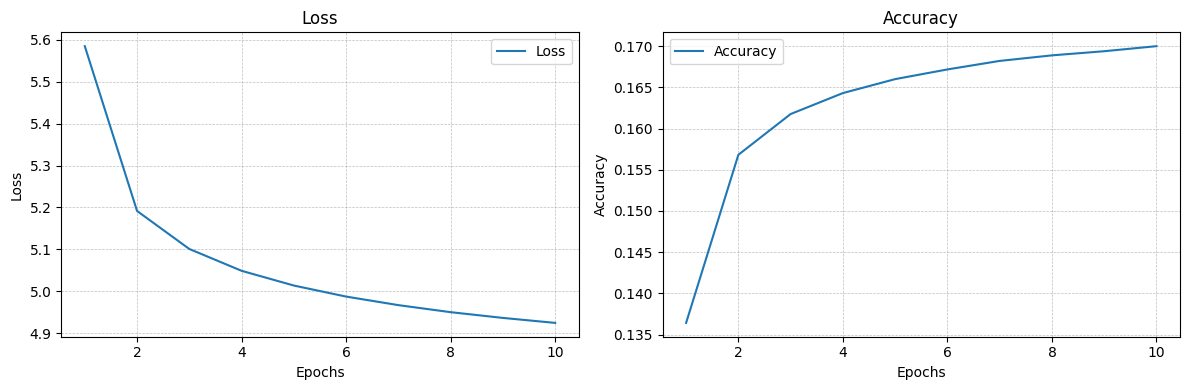

In [31]:
plt.figure(figsize=(12, 4))

ax1 = plt.subplot(1, 2, 1)
x = range(1, len(history.history['loss']) + 1)
plt.plot(x, history.history['loss'], label='Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.5)
plt.legend()

ax2 = plt.subplot(1, 2, 2)
plt.plot(x, history.history['accuracy'], label='Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.5)
plt.legend()

plt.tight_layout()
plt.show()


# Text generation

## <span style="color:red"><b>Task 3</b></span>

Utilize the language model to generate text by following these steps: Begin with a seed sentence, which you feed into the network. Select the word with the highest probability, append it to your initial sentence, and feed it back into your network to generate the following word. Repeat this process 10-20 times to generate a complete sentence.



In [39]:
def generate(seed_text):
    ### START CODE HERE ### 
    # Tokenize the seed text
    num_words = 10
    token_list = [word_index[word] for word in seed_text.split() if word in word_index]
    # Pad the token list to the required input sequence size
    token_list = pad_sequences([token_list], maxlen=input_seq_size-1, padding='pre')
    
    for _ in range(num_words):
        # Predict the next word
        predicted = model.predict(token_list, verbose=0)
        predicted_index = np.argmax(predicted, axis=-1)
        # Convert the index to the word
        next_word = id_to_word[predicted_index[0]]
        # Append the word to the input sequence
        token_list = np.append(token_list, predicted_index)
        token_list = token_list[1:].reshape(1, -1)
        seed_text += " " + next_word

    text = seed_text
    ### END CODE HERE ### 
    return text



Use your Languange Model with the following seed text:

In [40]:
seed_text = 'the movie is terrible'
generate(seed_text)

'the movie is terrible i have seen the movie is a good movie that'

# Congratulations!


Congratulations on completing the assignment! Your dedication and effort are commendable. By successfully working through the coding exercises and written exercises, you have demonstrated a strong understanding of Feedforward Neural Nets.






# Acknowledgement

## About the Author

This notebook was authored by Mohamed Reda Bouadjenek. He is a Senior Lecturer (Assistant Professor) of Applied Artificial Intelligence in the School of Information Technology at Deakin University, Australia.



## Disclaimer 

Even though your code passes all unit test cases, it does not guarantee absolute correctness. The complexity of real-world scenarios can sometimes lead to unforeseen edge cases that may not have been covered by the test suite. As a result, it's essential to exercise caution and conduct thorough testing to ensure the robustness and reliability of the code in all possible cases.

## Version History
- Version 1.0 (Initial Release): Released on 19/04/2024.

## Contact Information

- **Email:** reda.bouadjenek@deakin.edu.au
- **GitHub:** https://github.com/rbouadjenek/

---
